In [2]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.9 MB/s eta 0:00:00


In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Dense, Activation, Flatten


In [4]:
cwd = os.getcwd()
print(cwd)

/content


In [6]:
!wget https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/elephants.zip
!wget https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/not-elephants.zip

--2024-10-24 01:04:45--  https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/elephants.zip
Resolving www.ecst.csuchico.edu (www.ecst.csuchico.edu)... 132.241.1.13
Connecting to www.ecst.csuchico.edu (www.ecst.csuchico.edu)|132.241.1.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6994677 (6.7M) [application/zip]
Saving to: ‘elephants.zip.1’

elephants.zip.1     100%[===================>]   6.67M  28.5MB/s    in 0.2s    

2024-10-24 01:04:46 (28.5 MB/s) - ‘elephants.zip.1’ saved [6994677/6994677]

--2024-10-24 01:04:46--  https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/not-elephants.zip
Resolving www.ecst.csuchico.edu (www.ecst.csuchico.edu)... 132.241.1.13
Connecting to www.ecst.csuchico.edu (www.ecst.csuchico.edu)|132.241.1.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94474869 (90M) [application/zip]
Saving to: ‘not-elephants.zip.1’

not-elephants.zip.1 100%[===================>]  90.10M  90.4MB/s    in 1.0s    

202

In [7]:
!unzip elephants.zip
!unzip not-elephants.zip


Archive:  elephants.zip
   creating: elephants/
  inflating: elephants/ELEPHANT-9.wav  
  inflating: elephants/elephan6-1.wav  
  inflating: elephants/elephant-13.wav  
  inflating: elephants/elephant-18.wav  
  inflating: elephants/elephant-20.wav  
  inflating: elephants/trumpet31-1.wav  
  inflating: elephants/8d82b5_Elephant_Trumpet_Sound_Effect.wav  
  inflating: elephants/new-1.wav     
  inflating: elephants/ELEPHAN.wav   
  inflating: elephants/elephant-7.wav  
  inflating: elephants/elephantcub-1.wav  
  inflating: elephants/elephant-trumpets-growls-6047-1.wav  
  inflating: elephants/elephnt1-2.wav  
  inflating: elephants/marc_tstA_eleph-1.wav  
  inflating: elephants/elephant8-1.wav  
  inflating: elephants/elephant1-1.wav  
  inflating: elephants/elefant-1.wav  
  inflating: elephants/elephant3-1.wav  
  inflating: elephants/ELPHNTTR-1.wav  
  inflating: elephants/elephant_mkyvgtvo-1.wav  
  inflating: elephants/elephant2-1.wav  
  inflating: elephants/elephant-17.wav  
  

In [11]:
elefile = os.path.join('elephants', 'elephant9-1.wav')
notelefile = os.path.join('not-elephants', '2-guinea-fowl-24469-1.wav')


In [12]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [13]:
wave = load_wav_16k_mono(elefile)
nwave =load_wav_16k_mono(notelefile)

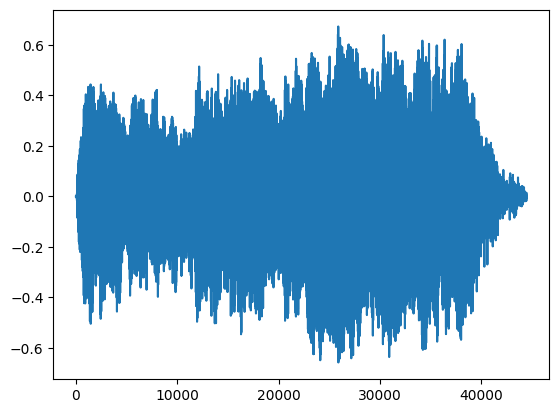

In [24]:
plt.plot(wave)
# plt.plot(nwave)
plt.show()

In [15]:
POS = os.path.join('elephants')
NEG = os.path.join('not-elephants')

In [16]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [17]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)
data.as_numpy_iterator().next()

(b'elephants/trumpet31-1.wav', 1.0)

In [19]:
lengths = []
for file in os.listdir(os.path.join('elephants')):
    tensor_wave = load_wav_16k_mono(os.path.join('elephants', file))
    lengths.append(len(tensor_wave))

In [20]:
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=41066>

In [21]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=920, frame_step=43)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [22]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [23]:
spectrogram, label = preprocess(filepath, label)


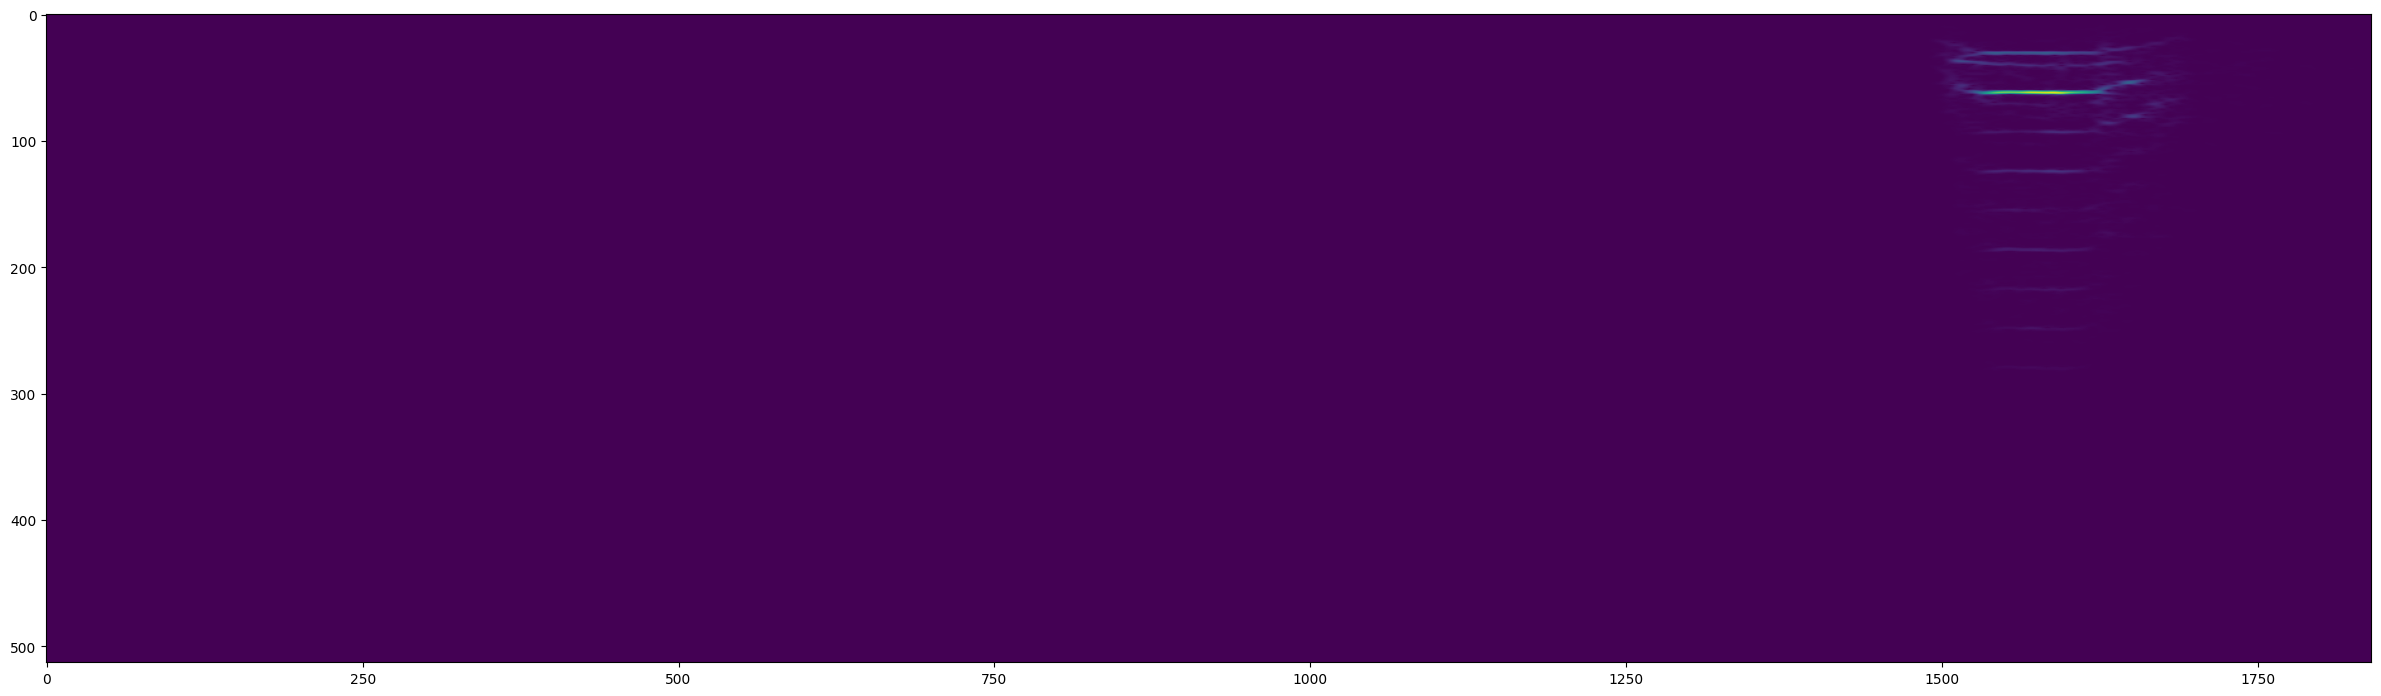

In [25]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [26]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=800)
data = data.batch(3)
data = data.prefetch(8)
data

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [27]:
spectrogram

<tf.Tensor: shape=(1840, 513, 1), dtype=float32, numpy=
array([[[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[1.4009127e-01],
        [5.5374049e-02],
        [3.4410734e-02],
        ...,
        [4.8865601e-08],
        [3.7859866e-08],
        [5.2154064e-08]],

       [[1.4879347e-01],
        [7.0237465e-02],
        [4.1596230e-02],
        ...,
        [4.7130811e-08],
        [3.3436944e-08],
        [4.4703484e-08]],

       [[1.6025013e-01],
        [9.0056024e-02],
        [5.0102081e-02],
        ...,
        [5.5736077

In [28]:
len(data)*.7

21.7

In [61]:
# why 59 and 26?
#train = data.take(60)
#test = data.skip(60).take(20)
from sklearn.model_selection import train_test_split
train_samples, test_samples, train_labels, test_labels = train_test_split(
    samples, labels, test_size=0.2, random_state=42
)  # Adjust test_size as needed

In [62]:
samples, labels = train.as_numpy_iterator().next()

model = Sequential()
model.add(Conv2D(3, (3,3), activation='relu', input_shape=(1840,513,1)))
model.add(Conv2D(3, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(27, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
model = Sequential()
model.add(Conv2D(3, (3,3), activation='relu', input_shape=(1840,513,1)))
model.add(Conv2D(3, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(27, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.Precision(name='precision')])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 1838, 511, 3)        │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1836, 509, 3)        │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2803572)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 27)                  │      75,696,471 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,696,613 (288.76 MB)

 Trainable params: 75,696,613 (288.76 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
print(type(test))
print(test.element_spec)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(TensorSpec(shape=(None, 1840, 513, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [74]:
#samples = samples.reshape(-1, 1840, 513, 1)
train = tf.data.Dataset.from_tensor_slices((samples, labels))
train = train.batch(32)
test = tf.data.Dataset.from_tensor_slices((samples, labels))
test = test.batch(32, drop_remainder=False)
#test = test.prefetch(tf.data.AUTOTUNE)

In [75]:
hist = model.fit(train, epochs=4, validation_data=test)
#hist = model.fit(train,epochs=4, validation_data=test)

Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000


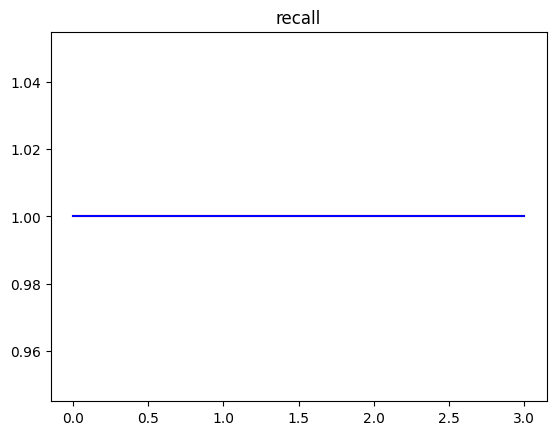

In [76]:
plt.title('recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

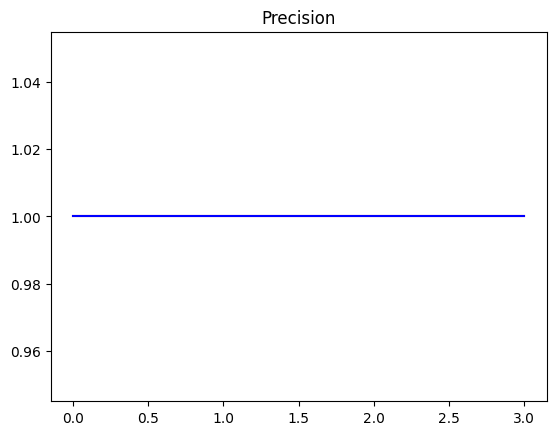

In [77]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

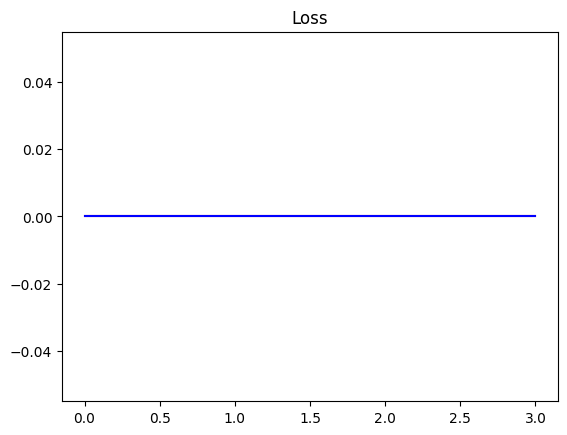

In [78]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [79]:
x_test,y_test = test.as_numpy_iterator().next()
y_test


array([1., 1., 1.], dtype=float32)

In [80]:
y_test.shape

(3,)

In [81]:
yhat = model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


In [82]:
# convert logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]#forloop

In [83]:
yhat

[1, 1, 1]

In [84]:
y_test.astype(int)

array([1, 1, 1])

In [85]:
#a. load up mp3s

def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [88]:
!wget https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/test-1.mp3
mp3=os.path.join('test-1.mp3')

--2024-10-24 01:49:52--  https://www.ecst.csuchico.edu/~sbsiewert/csci581/data/test-1.mp3
Resolving www.ecst.csuchico.edu (www.ecst.csuchico.edu)... 132.241.1.13
Connecting to www.ecst.csuchico.edu (www.ecst.csuchico.edu)|132.241.1.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 856557 (836K) [audio/mpeg]
Saving to: ‘test-1.mp3’

test-1.mp3          100%[===================>] 836.48K  5.32MB/s    in 0.2s    

2024-10-24 01:49:53 (5.32 MB/s) - ‘test-1.mp3’ saved [856557/856557]



In [89]:
wav = load_mp3_16k_mono(mp3)

In [90]:
# slice audio into the same size slices model was trained on
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=80000, sequence_stride=80000, batch_size=1)


In [91]:
samples, index = audio_slices.as_numpy_iterator().next()


In [92]:
samples.shape

(1, 80000)

In [93]:
# b. Build Function to Convert Clips into Windowed Spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([80000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=920, frame_step=43)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram


In [94]:
# convert longer clips into windows and make predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=80000, sequence_stride=80000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)


In [95]:
yhat = model.predict(audio_slices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [96]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]#forloop

In [97]:
yhat

[1, 1, 1, 1, 1, 1, 1]

In [98]:
len(yhat)

7

In [100]:
model.save('newdetection.keras')